# Preliminary exploration of iV2I+ sensor data

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import bagpy
from bagpy import bagreader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import rosbag
from datetime import datetime

from IPython.display import HTML

In [2]:
sensor_path = Path('../datacloud/enway/sensors/bag_4.bag')
b = bagreader(str(sensor_path))

[INFO]  Data folder ../datacloud/enway/sensors/bag_4 already exists. Not creating.


## Topic table - Summary of the sensor data

In [3]:
b.topic_table

,Topics,Types,Message Count,Frequency
0,/navigation/enway_map/far_map_obstacles,nav_msgs/OccupancyGrid,28993,20.074299
1,/navigation/enway_map/map_static_elevation,nav_msgs/OccupancyGrid,1,NaN
2,/navigation/enway_map/near_map_obstacles,nav_msgs/OccupancyGrid,28993,20.049063
3,/odom,nav_msgs/Odometry,144957,102300.097561
4,/sensors/inertial/imu,sensor_msgs/Imu,145016,98.524911
5,/sensors/lidar/lidar_top/points,sensor_msgs/PointCloud2,14504,10.000844
6,/tf,tf2_msgs/TFMessage,232113,144.870959
7,/tf_static,tf2_msgs/TFMessage,2,3113.811433
8,/velocity_command_multiplexer/drive_command,ackermann_msgs/AckermannDriveStamped,10703,20.006983
9,/wheel_odom,nav_msgs/Odometry,72493,82.164729


`/sensors/lidar/lidar_top/points` are partially used for
`far_map_obstacles` and `near_map_obstacles`, it also contains more information
on the z-axis, though.

## Odometry

Messages come with a timestamp and their structure is consistent within a topic, so they can be arranged as a dataframe

In [4]:
odom = b.message_by_topic('/odom')

In [5]:
odom_df = pd.read_csv(odom)
odom_df["Time"] = odom_df["Time"].apply(datetime.utcfromtimestamp)

In [6]:
odom_df

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,child_frame_id,pose.pose.position.x,pose.pose.position.y,pose.pose.position.z,pose.pose.orientation.x,...,pose.pose.orientation.z,pose.pose.orientation.w,pose.covariance,twist.twist.linear.x,twist.twist.linear.y,twist.twist.linear.z,twist.twist.angular.x,twist.twist.angular.y,twist.twist.angular.z,twist.covariance
0,2021-06-25 12:26:50.817139,211114,1624624010,816821814,odom,base_link,16.056161,4.193288,-4.053948,-0.010709,...,0.999863,0.011934,"(65.85976372508783, 0.46458271677317264, 0.029...",-0.000959,-0.000019,0.001675,0.000008,-0.000009,-0.000017,"(0.006328899831390716, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,2021-06-25 12:26:50.827152,211115,1624624010,826852560,odom,base_link,16.056169,4.193287,-4.053920,-0.010709,...,0.999862,0.011935,"(65.86009671373218, 0.4645819491901028, 0.0292...",-0.000934,-0.000032,0.003757,0.000007,-0.000010,-0.000017,"(0.006583510711230532, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2021-06-25 12:26:50.837251,211116,1624624010,836862326,odom,base_link,16.056161,4.193287,-4.053933,-0.010709,...,0.999862,0.011936,"(65.86039704815136, 0.46458194752569465, 0.029...",-0.000937,-0.000009,0.001703,0.000007,-0.000010,-0.000017,"(0.006330127907661963, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,2021-06-25 12:26:50.847180,211117,1624624010,846846342,odom,base_link,16.056171,4.193286,-4.053904,-0.010709,...,0.999862,0.011937,"(65.86072848696266, 0.4645811833779788, 0.0292...",-0.001065,-0.000005,0.003802,0.000007,-0.000010,-0.000018,"(0.006583548466059274, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,2021-06-25 12:26:50.857326,211118,1624624010,856929779,odom,base_link,16.056161,4.193286,-4.053917,-0.010709,...,0.999862,0.011938,"(65.8610312651172, 0.46458117611873434, 0.0292...",-0.000964,0.000005,0.001727,0.000007,-0.000010,-0.000018,"(0.006331950587917304, 0.0, 0.0, 0.0, 0.0, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144952,2021-06-25 12:51:01.032596,356066,1624625461,31993389,odom,base_link,1.527922,1.042021,-3.555028,-0.010752,...,0.935999,0.351838,"(110.86004572960319, 0.3235841740500025, 0.065...",-0.001063,0.000017,0.000768,0.000016,-0.000046,-0.000067,"(0.006226742947970759, 0.0, 0.0, 0.0, 0.0, 0.0..."
144953,2021-06-25 12:51:01.078643,356067,1624625461,39722204,odom,base_link,1.527928,1.042016,-3.555015,-0.010751,...,0.935997,0.351842,"(110.8602912936846, 0.323572185976864, 0.06569...",-0.001015,0.000051,0.002263,0.000016,-0.000046,-0.000070,"(0.006422611269805068, 0.0, 0.0, 0.0, 0.0, 0.0..."
144954,2021-06-25 12:51:01.078657,356068,1624625461,49716949,odom,base_link,1.527921,1.042023,-3.555019,-0.010751,...,0.935996,0.351845,"(110.8605915966503, 0.32357178828441724, 0.065...",-0.001071,0.000006,0.000341,0.000016,-0.000046,-0.000069,"(0.006168697958762092, 0.0, 0.0, 0.0, 0.0, 0.0..."
144955,2021-06-25 12:51:01.078662,356069,1624625461,59748411,odom,base_link,1.527928,1.042016,-3.555006,-0.010750,...,0.935996,0.351847,"(110.86091024822242, 0.32355629156810867, 0.06...",-0.001093,0.000036,0.002272,0.000017,-0.000046,-0.000071,"(0.006423295103924491, 0.0, 0.0, 0.0, 0.0, 0.0..."


### Comments on odometry

- Position is given in `pose.pose.position.[x/y/z]` relative to the origin of the [static map](#Occupancy-grids)
- Orientation of the robot is given in `pose.pose.orientation.[x/y/z/w]`
as a quaternion; transformation to pitch-yaw-roll may be needed.

Text(136.97222222222223, 0.5, 'y')

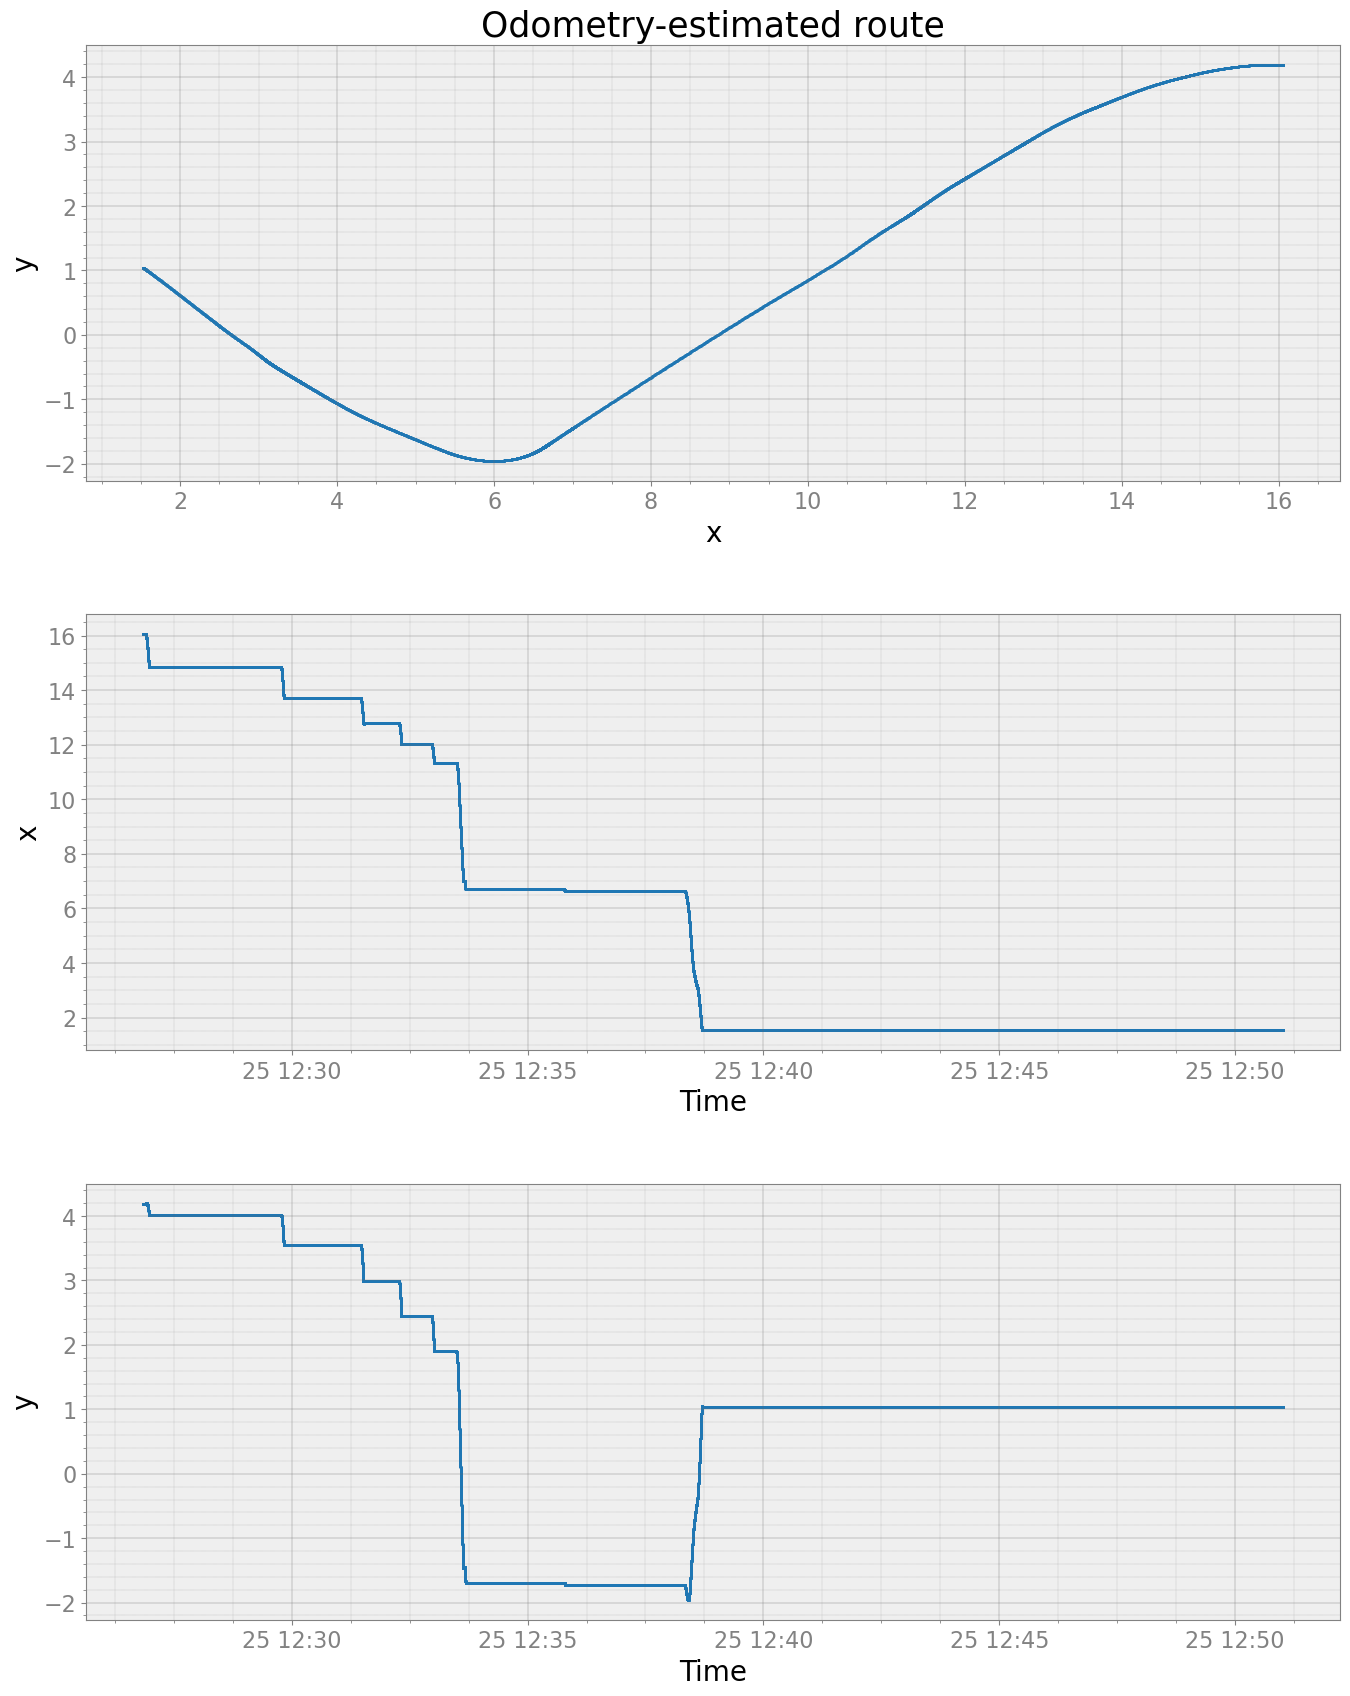

In [7]:
fig, ax = bagpy.create_fig(3)
ax[0].scatter(x = 'pose.pose.position.x', y = 'pose.pose.position.y', data  = odom_df, s= 1, label = 'Odometry positions')
ax[0].set_title("Odometry-estimated route")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].scatter(x = 'Time', y = 'pose.pose.position.x', data  = odom_df, s= 1)
ax[1].set_xlabel("Time")
ax[1].set_ylabel("x")

ax[2].scatter(x = 'Time', y = 'pose.pose.position.y', data  = odom_df, s= 1)
ax[2].set_xlabel("Time")
ax[2].set_ylabel("y")

## Occupancy grids

Some data fields of certain message types (occupancy grids, point clouds...) are multidimensional, although they are sent in flat form

In [8]:
elevation_map = b.message_by_topic('/navigation/enway_map/map_static_elevation')
elevation_df = pd.read_csv(elevation_map)

In [9]:
map_shape = elevation_df[["info.width", "info.height"]].to_numpy().flatten()

In [10]:
elev_series = elevation_df.T[0]
elev_map = np.reshape(np.array(elev_series[elev_series.index.str.contains('data_')], dtype=int), map_shape)

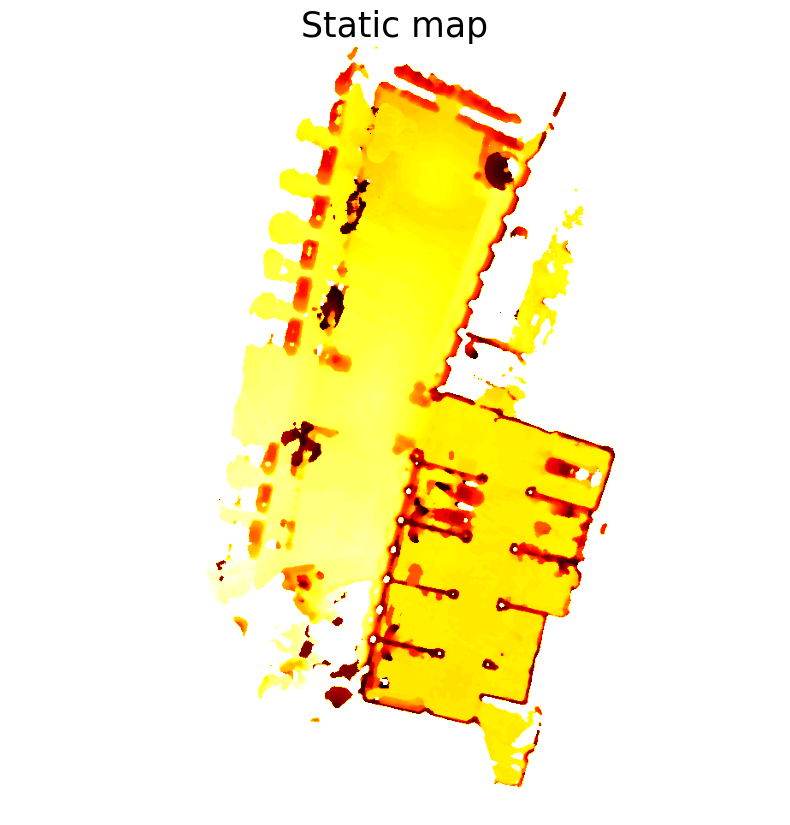

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(elev_map[:900, :900], cmap='hot_r')
_ = plt.title("Static map")
_ = plt.axis('off')

In [12]:
bag = rosbag.Bag(sensor_path)

In [13]:
far_map = "/navigation/enway_map/far_map_obstacles"
near_map = "/navigation/enway_map/near_map_obstacles"
far_freq = b.topic_table.query("Topics == @far_map")["Frequency"].iloc[0]
near_freq = b.topic_table.query("Topics == @near_map")["Frequency"].iloc[0]
total_freq = far_freq + near_freq

time_offset = 6 * 60 + 31
time_seconds = 30
map_length = round(time_seconds * total_freq)
offset = round(time_offset * total_freq)


In [14]:
far_data = []
far_time = []
near_data = []
near_time = []
count = 0
for topic, msg, t in tqdm(bag.read_messages(topics=[far_map, near_map]), total=map_length+offset):
    count += 1
    if count > offset:
        shape = msg.info.width, msg.info.height
        dt = datetime.utcfromtimestamp(t.to_sec())
        if topic == far_map:
            far_time.append(dt)
            far_data.append(np.reshape(msg.data, shape))
        elif topic == near_map:
            near_time.append(dt)
            near_data.append(np.reshape(msg.data, shape))
    if count > map_length+offset:
        break

max_v = max(np.max(near_data), np.max(far_data))
min_v = min(np.min(near_data), np.min(far_data))

  0%|          | 0/16892 [00:00<?, ?it/s]

In [15]:
def create_title(dt):
    return dt.strftime("%d-%m-%Y at %H:%M:%S.%f")[:-5]

In [16]:
%%capture

interval_ms = 1000 / far_freq

fig, (ax_far, ax_near) = plt.subplots(1, 2, figsize=(12,6))

im_far = ax_far.imshow(far_data[0], cmap='hot_r', vmin=min_v, vmax=max_v)
im_near = ax_near.imshow(near_data[0], cmap='hot_r', vmin=min_v, vmax=max_v)
_ = ax_far.set_title("Far map obstacles")
_ = ax_near.set_title("Near map obstacles")
_ = fig.suptitle(create_title(far_time[0]))

# animation function. This is called sequentially
def animate(i):
    im_far.set_array(far_data[i])
    im_near.set_array(near_data[i])
    fig.suptitle(create_title(far_time[i]))
    return [im_far, im_near]

anim_obj = manimation.FuncAnimation(
    fig,
    # The function that does the updating of the Figure
    animate,
    frames=len(far_time),
    interval=interval_ms,
    blit=True
)

In [ ]:
HTML(anim_obj.to_html5_video())

Obstacle maps are relative to the robot position and orientation.
Metadata as resolution can be extracted from the bag's headers in accordance with ROS documentation